In [1]:
#$ Imports
import os
import sys
import json
from datetime import datetime

import random
import numpy as np
import scipy as sc
from scipy import stats
import pandas as pd
import xarray as xr
import cftime
from dask.diagnostics import ProgressBar
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean as cmo

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

import utils
from utils import settings

In [2]:
#$ Global variables
with open("~/s2s/paths.json") as paths_json:
    PATHS = json.load(paths_json)
with open("~/s2s/globals.json") as globals_json:
    GLOBALS = json.load(globals_json)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    print(f"Using cuda device {torch.cuda.get_device_name(0)}")

plt.style.use('bmh')
plt.rcParams['mathtext.fontset'] = 'custom'

$WORK/conda-envs/s2s/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Computing and saving tensors for different lags

In [3]:
def get_data(tau, icoord):
    # Paths
    data_path = os.path.join(PATHS['full_globe'], 'data', f'tau_{tau}')
    network_path = os.path.join(PATHS['full_globe'], f'networks/tau_{tau}/loc_{icoord}')
    predictions_path = os.path.join(PATHS['full_globe'], f'predictions/tau_{tau}/loc_{icoord}')
    
    # Get lat and lon indices
    icoords_list = np.load(os.path.join(data_path, 'icoords.npy'))
    ilat, ilon = icoords_list[icoord]
    lat, lon = utils.helpers.get_lat_lon_from_icoord(icoord)
    point = {'lat': lat, 'lon': lon}
    
    # Target data
    y_test_darray = xr.open_dataarray(os.path.join(data_path, 'y_test.nc'))
    y_test_tensor = torch.load(os.path.join(data_path, 'y_test_tensor.pt'))
    target_z = y_test_tensor.numpy()
    target_z = target_z[:, ilat, ilon]
    
    # Standardizers
    # y_scaler = xr.open_dataset(os.path.join(data_path, 'y_standardizer.nc'))
    # y_scaler = y_scaler.sel(lat=lat, lon=lon, method='nearest')
    residual_scaler = utils.processing.load_standardizer(network_path, 'residual')
    
    # Select target values at location
    pred_mean_z = np.load(os.path.join(predictions_path, 'pred_mean_z.npy'))
    pred_logvar_z = np.load(os.path.join(predictions_path, 'pred_logvar_z.npy'))
    pred_std_z = np.sqrt(np.exp(pred_logvar_z))
    pred_std_z = utils.processing.unstandardize(pred_std_z, residual_scaler)
    # Make stuff into dataarrays
    time = xr.CFTimeIndex(y_test_darray['time'].values)
    target_z = xr.DataArray(target_z, dims=('time',), coords={'time':time})
    pred_mean_z = xr.DataArray(pred_mean_z, dims=('time',), coords={'time':time})
    pred_std_z = xr.DataArray(pred_std_z, dims=('time',), coords={'time':time})
    
    # # Get damped persistence predictions as well
    # y_scaler = utils.processing.load_standardizer(data_path, 'y')
    # y_scaler = y_scaler.sel(lat=lat, lon=lon, method='nearest')
    
    # dp_pred_z = xr.open_dataarray(os.path.join(PATHS['full_globe'], f'predictions/tau_{tau}/dp_pred.nc'))
    # dp_pred_z = dp_pred_z.sel(lat=lat, lon=lon, method='nearest')
    
    # Positive prediction stuff
    # is_positive = (target_z > 0).astype(np.float64)
    # logreg_preds = xr.open_dataarray(os.path.join(PATHS['full_globe'], f'predictions/tau_{tau}/logreg_prob_pos.nc'))
    # logreg_preds = logreg_preds.sel(lat=lat, lon=lon, method='nearest')
    
    # prob_pos = xr.DataArray(
    #     stats.norm.sf(0, loc=pred_mean_z, scale=pred_std_z),
    #     dims='time', coords={'time': time}
    # )

    return target_z, pred_mean_z, pred_std_z

## Compute probabilities

In [4]:
taus = np.array([10, 20, 30, 40, 50, 60, 90, 120, 150, 180])
icoord = 4710
lat, lon = utils.helpers.get_lat_lon_from_icoord(icoord)

conf_threshold = 0.2

In [5]:
target_ds = xr.Dataset()
pred_mean_ds = xr.Dataset()
pred_std_ds = xr.Dataset()
logreg_preds_ds = xr.Dataset()

for i, tau in enumerate(tqdm(taus)):
    target_z, pred_mean_z, pred_std_z = get_data(tau, icoord)
    target_ds[tau] = target_z
    pred_mean_ds[tau] = pred_mean_z
    pred_std_ds[tau] = pred_std_z
    
    logreg_prob_pos = xr.open_dataarray(os.path.join(
        PATHS['full_globe'], f'predictions/tau_{tau}/logreg_prob_pos.nc'))
    logreg_prob_pos = logreg_prob_pos.sel(lat=lat, lon=lon, method='nearest')
    logreg_preds_ds[tau] = logreg_prob_pos

target_all = target_ds.to_array(dim='tau')
pred_mean_all = pred_mean_ds.to_array(dim='tau')
pred_std_all = pred_std_ds.to_array(dim='tau')
logreg_preds_all = logreg_preds_ds.to_array(dim='tau')

100%|██████████| 10/10 [00:45<00:00,  4.51s/it]


In [6]:
# Compute positive probabilities for ANN
ann_prob_pos = xr.DataArray(
    np.full((18321, len(taus)), np.nan),
    dims=('time', 'tau'),
    coords={'time': target_all['time'], 'tau': taus}
)
for i, tau in enumerate(taus):
    ann_prob_pos[:,i] = stats.norm.sf(
        0, loc=pred_mean_all.sel(tau=tau), scale=pred_std_all.sel(tau=tau)
    )

## Brier scores

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


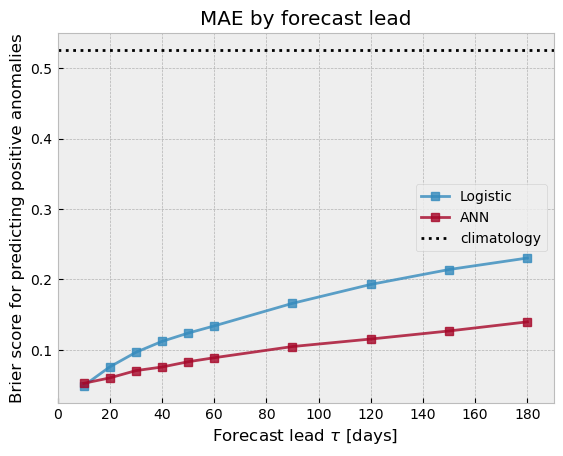

In [7]:
# Compute Brier scores
ispositive = (target_all > 0).astype(np.float64)
brier_logreg = ((ispositive - logreg_preds_all)**2).mean(dim='time')
brier_ann = ((ispositive - ann_prob_pos)**2).mean(dim='time')
brier_clim = (ispositive**2).mean(dim='time').isel(tau=0).item()

fig, ax = plt.subplots()
kwargs = {'alpha': 0.8, 'marker': 's'}

brier_logreg.plot(ax=ax, ls='-', color='C0', **kwargs, label='Logistic')
brier_ann.plot(ax=ax, ls='-', color='C1', **kwargs, label='ANN')
ax.plot([0, 190], [brier_clim, brier_clim], ls=':', color='k', label='climatology')
ax.set(
    title=f'MAE by forecast lead',
    xlabel=r'Forecast lead $\tau$ [days]',
    xticks=np.arange(0, 190, 20),
    xlim=(0,190),
    ylabel='Brier score for predicting positive anomalies',
    # ylim=(0,0.8)
);

ax.legend()

## Distribution of positive anomaly predictions by forecast lead

In [12]:
icoords = [4710, 3282]

N_lags = len(taus)
cmap = cmo.tools.crop_by_percent(cmo.cm.thermal, 10, which='max')
norm = plt.Normalize(0, N_lags)

100%|██████████| 10/10 [01:01<00:00,  6.15s/it]


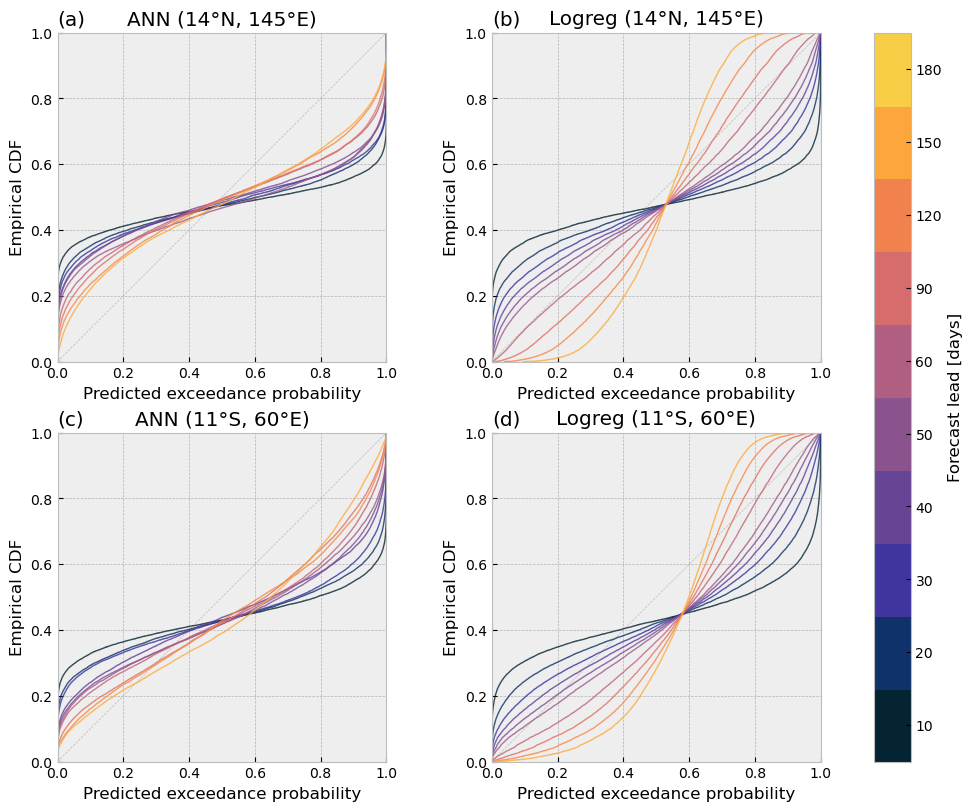

In [13]:
fig, axes = plt.subplot_mosaic([['a', 'b'], ['c', 'd']], figsize=(10,8), layout='constrained')

for icoord, (label0, label1) in zip(icoords, [['a', 'b'], ['c', 'd']]):
    lat, lon = utils.helpers.get_lat_lon_from_icoord(icoord)
    lat, lon = np.round(lat), np.round(lon)

    target_ds = xr.Dataset()
    pred_mean_ds = xr.Dataset()
    pred_std_ds = xr.Dataset()
    logreg_preds_ds = xr.Dataset()
    
    for i, tau in enumerate(tqdm(taus)):
        target_z, pred_mean_z, pred_std_z = get_data(tau, icoord)
        target_ds[tau] = target_z
        pred_mean_ds[tau] = pred_mean_z
        pred_std_ds[tau] = pred_std_z
        
        logreg_prob_pos = xr.open_dataarray(os.path.join(
            PATHS['full_globe'], f'predictions/tau_{tau}/logreg_prob_pos.nc'))
        logreg_prob_pos = logreg_prob_pos.sel(lat=lat, lon=lon, method='nearest')
        logreg_preds_ds[tau] = logreg_prob_pos
    
    target_all = target_ds.to_array(dim='tau')
    pred_mean_all = pred_mean_ds.to_array(dim='tau')
    pred_std_all = pred_std_ds.to_array(dim='tau')
    logreg_preds_all = logreg_preds_ds.to_array(dim='tau')
    
    for i, tau in enumerate(taus):
        pred_mean_z = pred_mean_all.sel(tau=tau)
        pred_std_z = pred_std_all.sel(tau=tau)
    
        prob_pos = xr.DataArray(
            stats.norm.sf((0-pred_mean_z) / pred_std_z), coords={'time': pred_mean_z['time']}
        )
        axes[label0].step(np.sort(prob_pos), np.linspace(0, 1, len(prob_pos)), color=cmap(norm(i)), alpha=0.8, lw=1)
    
        # Logistic regression
        logreg_prob_pos = logreg_preds_all.sel(tau=tau)
        axes[label1].step(np.sort(logreg_prob_pos), np.linspace(0, 1,len(logreg_prob_pos)), color=cmap(norm(i)), alpha=0.8, lw=1)

    # Titles
    if lat >= 0:
        printcoords = f'({int(lat)}\u00b0N, {int(lon)}\u00b0E)'
    else:
        printcoords = f'({-int(lat)}\u00b0S, {int(lon)}\u00b0E)'
    axes[label0].set(title=f'ANN {printcoords}')
    axes[label1].set(title=f'Logreg {printcoords}')
    
cax = axes['d'].pcolormesh([[]], vmin=0, vmax=len(taus), cmap=cmap.resampled(N_lags))
cb = plt.colorbar(cax, ax=axes.values(), ticks=np.arange(0.5, len(taus)), label='Forecast lead [days]')
cb.set_ticklabels(taus)
cb.solids.set_edgecolor('face')

for label, ax in axes.items():
    ax.plot([0,1], [0,1], ls='--', color='#bbbbbb', lw=0.5, zorder=1)
    ax.set(
        xlabel='Predicted exceedance probability',
        ylabel='Empirical CDF',
        xlim=(0,1),
        ylim=(0,1),
        aspect='equal'
    )

for label, ax in axes.items():
    ax.set_title(f'({label})', loc='left')

plt.savefig('predicted_prob_dist.pdf', dpi=300, bbox_inches='tight')

In [36]:
for icoord in [4710, 3282]:
    print(f"Location {icoord}")
    print("=" * 80)
    lat, lon = utils.helpers.get_lat_lon_from_icoord(icoord)

    # Get prob positive
    target_ds = xr.Dataset()
    pred_mean_ds = xr.Dataset()
    pred_std_ds = xr.Dataset()
    logreg_preds_ds = xr.Dataset()
    for i, tau in enumerate(tqdm(taus)):
        target_z, pred_mean_z, pred_std_z = get_data(tau, icoord)
        target_ds[tau] = target_z
        pred_mean_ds[tau] = pred_mean_z
        pred_std_ds[tau] = pred_std_z
        
        logreg_prob_pos = xr.open_dataarray(os.path.join(
            PATHS['full_globe'], f'predictions/tau_{tau}/logreg_prob_pos.nc'))
        logreg_prob_pos = logreg_prob_pos.sel(lat=lat, lon=lon, method='nearest')
        logreg_preds_ds[tau] = logreg_prob_pos
    target_all = target_ds.to_array(dim='tau')
    pred_mean_all = pred_mean_ds.to_array(dim='tau')
    pred_std_all = pred_std_ds.to_array(dim='tau')
    logreg_preds_all = logreg_preds_ds.to_array(dim='tau')

    for i, tau in enumerate(taus):
        pred_mean_z = pred_mean_all.sel(tau=tau)
        pred_std_z = pred_std_all.sel(tau=tau)
    
        prob_pos = xr.DataArray(
            stats.norm.sf((0-pred_mean_z) / pred_std_z), coords={'time': pred_mean_z['time']}
        )
        
        conf_probs = (prob_pos < 0.05) + (prob_pos > 0.95)
        conf_probs = conf_probs.mean(dim='time')
    
        logreg_prob_pos = logreg_preds_all.sel(tau=tau)
        logreg_conf_probs = (logreg_prob_pos < 0.05) + (logreg_prob_pos > 0.95)
        logreg_conf_probs = logreg_conf_probs.mean(dim='time')
    
        print("tau = {:3d}  ANN: {:6.4f}  Logreg  {:6.4f}".format(tau,  conf_probs.item(), logreg_conf_probs.item()))

Location 4710


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


tau =  10  ANN: 0.7652  Logreg  0.7123
tau =  20  ANN: 0.6753  Logreg  0.5600
tau =  30  ANN: 0.6490  Logreg  0.4498
tau =  40  ANN: 0.6081  Logreg  0.3637
tau =  50  ANN: 0.6008  Logreg  0.2885
tau =  60  ANN: 0.5851  Logreg  0.2218
tau =  90  ANN: 0.5034  Logreg  0.0728
tau = 120  ANN: 0.4685  Logreg  0.0111
tau = 150  ANN: 0.3990  Logreg  0.0008
tau = 180  ANN: 0.3670  Logreg  0.0000
Location 3282


100%|██████████| 10/10 [00:27<00:00,  2.72s/it]

tau =  10  ANN: 0.7136  Logreg  0.6345
tau =  20  ANN: 0.6308  Logreg  0.4579
tau =  30  ANN: 0.5831  Logreg  0.3296
tau =  40  ANN: 0.4858  Logreg  0.2416
tau =  50  ANN: 0.4508  Logreg  0.1766
tau =  60  ANN: 0.4242  Logreg  0.1299
tau =  90  ANN: 0.3696  Logreg  0.0489
tau = 120  ANN: 0.2951  Logreg  0.0207
tau = 150  ANN: 0.2920  Logreg  0.0070
tau = 180  ANN: 0.2227  Logreg  0.0029
